# Regitros atvirų duomenų analizė

Data: 2019-12-03

Autorius: © 2019 Algirdas Kartavičius, algirdas.kartavicius@ktu.edu. 

## Analizė atsako į šiuos klausimus:
1. [Kaip įregistruojamų automobilių kuro tipas priklauso nuo eksporto šalies](#Kaip-įregistruojamų-automobilių-kuro-tipas-priklauso-nuo-eksporto-šalies?)?
1. [Kaip kinta įregistruojamų automobilių populiarumas pagal markę](#Kaip-kinta-įregistruojamų-automobilių-populiarumas-pagal-markę?)?
1. [Kaip keisis elektrinių automobolių naudojimas Lietuvoje](#Kaip-keisis-elektrinių-automobolių-naudojimas-Lietuvoje?)? (MM)
1. [Kokiu tikslumu galima nustatyti automobilio kuro-rūšį pagal pirmos registracijos datą, sandorio datą ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-kuro-rūšį-pagal--pirmos-registracijos-datą,-sandorio-datą-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-markę-pagal-pagaminimo-datą,-sandorio-datą,-galią,-darbinį-tūrį-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio kainą](#Kokiu-tikslumu-galima-nustatyti-automobilio-kainą?) (MM2)

## Pasitelkiami duomenų šaltiniai:
* https://www.regitra.lt/lt/atviri-duomenys
* https://www.regitra.lt/lt/paslaugos/duomenu-teikimas/atviri-duomenys-1  

Duomenys išfiltruojami naudojant jupyter notebook, kuris yra pateikiamas kartu. Išfiltruoti duomenys išsaugojami į archyvą "data2.zip", kuris ir naudojamas atsakyti visus klausimus.

# [Išvados ir pastebėjimai](#Išvados,-pastebėjimai)

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import io, requests
sns.set()
import datetime as dt
from datetime import date
import zipfile
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
pirm_reg = 'PIRM_REG_DATA_LT'
kuras = ['Dyzelinas', 'Benzinas']

Nuskaitomi duomenys ir atliekami pradiniai veiksmai su duomenimis: išfiltruojamos eilutės, kuriose nėra pirmosios registracijos Lietuvoje datos bei pirmosios registracijos Lietuvoje stulpelio duomenys pakeičiami į datos formatą.

In [2]:
zf = zipfile.ZipFile('data2.zip')
raw_data = pd.read_csv(zf.open('exported_car_model_data.csv'), sep=',', error_bad_lines=False, index_col=False, encoding="ISO-8859-1") 
raw_data.head()

,MARKE,PIRM_REG_DATA_LT,PASKUTINES_REG_DATA,DEGALAI,KILMES_SALIS,SANDORIO_SUMA,VALIUTA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
0,MAZDA,2016-01-04,2016-01-04,Dyzelinas,NaN,25000.0,EUR,2015-01-04,110.0,2191.0,2016-01-04
1,SUBARU,2016-01-06,2016-01-06,Benzinas,NaN,33900.0,EUR,2015-01-04,129.0,2498.0,2016-01-06
2,HYUNDAI,2016-01-11,2016-01-11,Dyzelinas,SWE,700.0,EUR,2015-01-05,83.0,1991.0,2002-06-27
3,MERCEDES BENZ,2016-01-13,2016-01-13,Dyzelinas,DEU,3500.0,EUR,2015-01-12,90.0,2874.0,1997-09-29
4,LOHR,2016-01-12,2016-01-12,--,FRA,NaN,EUR,2015-01-15,NaN,NaN,1999-10-11


## Kaip įregistruojamų automobilių kuro tipas priklauso nuo eksporto šalies?

Išfiltruojamos duomenų eilutės, kuriose nėra informacijos. Taip pat pastebėjau, kad stulpelyje "DEGALAI" kai kur yra simboliai "--", jie taip pat pašalinami.


In [3]:
fuel_data = raw_data[raw_data['KILMES_SALIS'].notnull()]
fuel_data = fuel_data[fuel_data['DEGALAI'].notnull()]
fuel_data = fuel_data[fuel_data['DEGALAI'] != '--']
fuel_data = fuel_data[fuel_data['PIRM_REG_DATA_LT'] < '2019']
fuel_data['PIRM_REG_DATA_LT'] =pd.to_datetime(fuel_data['PIRM_REG_DATA_LT'], errors='coerce')
fuel_data.head()

,MARKE,PIRM_REG_DATA_LT,PASKUTINES_REG_DATA,DEGALAI,KILMES_SALIS,SANDORIO_SUMA,VALIUTA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
2,HYUNDAI,2016-01-11,2016-01-11,Dyzelinas,SWE,700.0,EUR,2015-01-05,83.0,1991.0,2002-06-27
3,MERCEDES BENZ,2016-01-13,2016-01-13,Dyzelinas,DEU,3500.0,EUR,2015-01-12,90.0,2874.0,1997-09-29
7,VOLKSWAGEN,2016-01-13,2016-01-13,Benzinas / Dujos,DEU,900.0,EUR,2015-04-12,55.0,1781.0,1994-05-02
8,SCANIA,2016-01-15,2017-02-20,Dyzelinas,BEL,9000.0,EUR,2015-06-03,294.0,11705.0,1996-08-02
12,MAN,2016-01-08,2016-01-08,Dyzelinas,DEU,22000.0,EUR,2015-07-14,338.0,12816.0,2001-04-06


Išanalizavus duomenis buvo nuspręsta lyginti populiariausias degalų rūšis benziną ir dyzeliną, kadangi šios rūšys yra populiariausios. Išrenkami duomenys tik tų šalių iš kurių eksportuota bent po 500 kiekvienos rūšies   automobilių ir šis skaičius buvo bent didesnis nei 500 nuo 2016 iki 2019.

In [4]:
grouped_fuel = fuel_data.groupby([fuel_data ['PIRM_REG_DATA_LT'].dt.year,'KILMES_SALIS', 'DEGALAI'])['DEGALAI'].count().to_frame('FUEL_COUNT').reset_index()
filtered_fuel =grouped_fuel[grouped_fuel['FUEL_COUNT'] > 500]

fuel_final = filtered_fuel[filtered_fuel['DEGALAI'].isin(kuras) ]
fuel_df =  fuel_final.groupby([fuel_final['KILMES_SALIS']])['PIRM_REG_DATA_LT'].count().to_frame('FUEL_COUNT2').reset_index()
filtered_fuel_df = fuel_df['FUEL_COUNT2'] == 6

filtered_final_fuel_df  = fuel_final['KILMES_SALIS'].isin(fuel_df[filtered_fuel_df]['KILMES_SALIS']) 
final2 = fuel_final[filtered_final_fuel_df]
grouped_fuel = final2.groupby(['DEGALAI', 'KILMES_SALIS'])
final2.head(10)

,PIRM_REG_DATA_LT,KILMES_SALIS,DEGALAI,FUEL_COUNT
12,2016,BEL,Benzinas,580
16,2016,BEL,Dyzelinas,8636
29,2016,CHE,Benzinas,575
33,2016,CHE,Dyzelinas,784
40,2016,DEU,Benzinas,8640
46,2016,DEU,Dyzelinas,39300
68,2016,FRA,Benzinas,1333
72,2016,FRA,Dyzelinas,17448
94,2016,ITA,Benzinas,1010
99,2016,ITA,Dyzelinas,6435


Text(0.5, 1.0, 'Benzino populiarumas pagal valstybę 2016 - 2018')

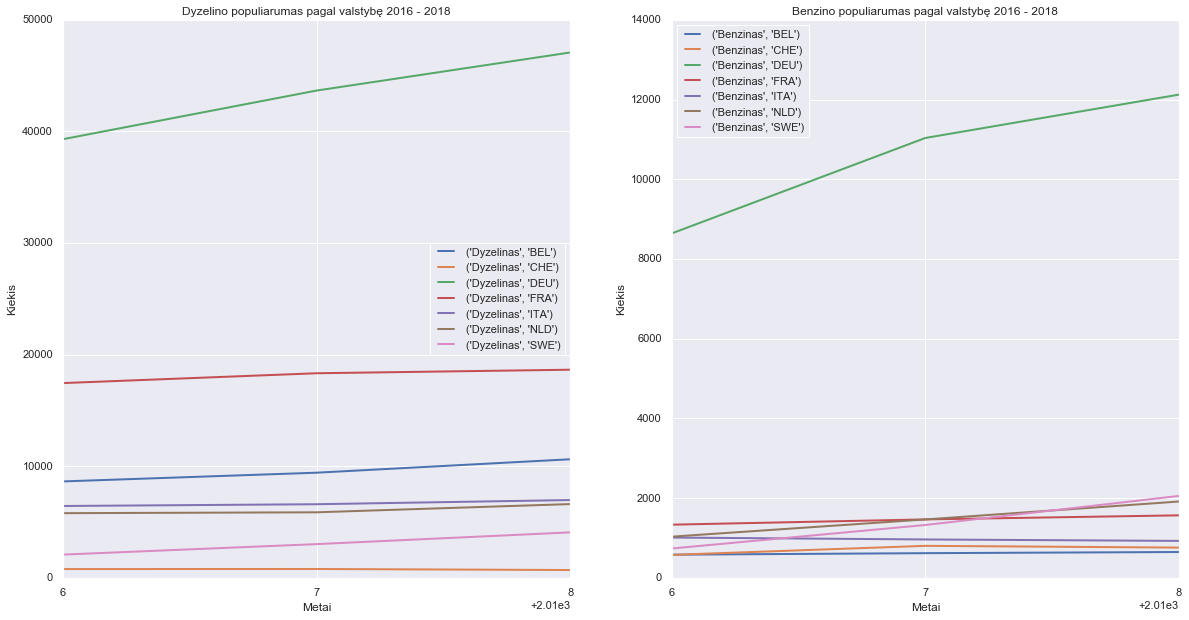

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.xticks(np.arange(2016, 2020, 1.0))
for key, item in grouped_fuel:
    if key[0] == 'Dyzelinas':
        plt.plot( 'PIRM_REG_DATA_LT', 'FUEL_COUNT', data=grouped_fuel.get_group(key), marker='', linewidth=2, label=key)
plt.legend(loc='best')
plt.xlabel('Metai')
plt.ylabel('Kiekis')
plt.title('Dyzelino populiarumas pagal valstybę 2016 - 2018')

plt.subplot(1, 2, 2)
plt.xticks(np.arange(2016, 2020, 1.0))
for key, item in grouped_fuel:
    if key[0] == 'Benzinas':
        plt.plot( 'PIRM_REG_DATA_LT', 'FUEL_COUNT', data=grouped_fuel.get_group(key), marker='', linewidth=2, label=key)
plt.legend(loc='best')
plt.xlabel('Metai')
plt.ylabel('Kiekis')
plt.title('Benzino populiarumas pagal valstybę 2016 - 2018')

#### Grafikuose matoma, kad daugiausiai benzininių bei dyzelinių automobilių eksportuojama iš Vokietijos. Antroje vietoje dyzelinių automobilių eksporte visus ketverius metus buvo Prancūzija, tačiau pažiūrėjus į automobilių su benzininiais varikliais grafiką matoma, kad čia aiškios antros vietos nėra, eksportuojamų automobilių kiekis iš visų valstybių yra panašus.

## Kaip kinta įregistruojamų automobilių populiarumas pagal markę?

Išrenkamos automobilių markės, kurių kiekis kiekvienais metais didesnis nei 5000.

In [6]:
brand_data = raw_data[raw_data[pirm_reg].notnull()]
brand_data = brand_data[brand_data['PIRM_REG_DATA_LT'] < '2019']
brand_data[pirm_reg] =pd.to_datetime(brand_data[pirm_reg], errors='coerce')
grouped_popular = brand_data.groupby([brand_data [pirm_reg].dt.year,'MARKE'])['MARKE'].count().to_frame('MARKE_COUNT').reset_index()
filtered_popular =grouped_popular[grouped_popular['MARKE_COUNT'] > 5000]

Išrenkami duomenys tik apie tas Markes, apie kurias yra visų 4 metų informacija

In [7]:
brand_df =  filtered_popular.groupby([filtered_popular['MARKE'],])[pirm_reg].count().to_frame('MARKE_COUNT_YEAR').reset_index()
filtered_markes_df = brand_df['MARKE_COUNT_YEAR'] == 3
filtered_markes = filtered_popular['MARKE'].isin(brand_df[filtered_markes_df]['MARKE'])
final_popular_brand_df = filtered_popular[filtered_markes]
grouped = final_popular_brand_df.groupby(['MARKE'])
final_popular_brand_df.head(10)

,PIRM_REG_DATA_LT,MARKE,MARKE_COUNT
35,2016,AUDI,10749
65,2016,BMW,8828
193,2016,FORD,5697
422,2016,MERCEDES BENZ,7273
482,2016,Nuasmeninta,9602
492,2016,OPEL,14460
664,2016,TOYOTA,12355
705,2016,VOLKSWAGEN,19957
706,2016,VOLVO,8865
789,2017,AUDI,12766


Duomenys sugrupuojami pagal markę, diagramoje matoma, kaip kinta automobilių markių kiekis.

Text(0.5, 1.0, 'Markės populiarumas')

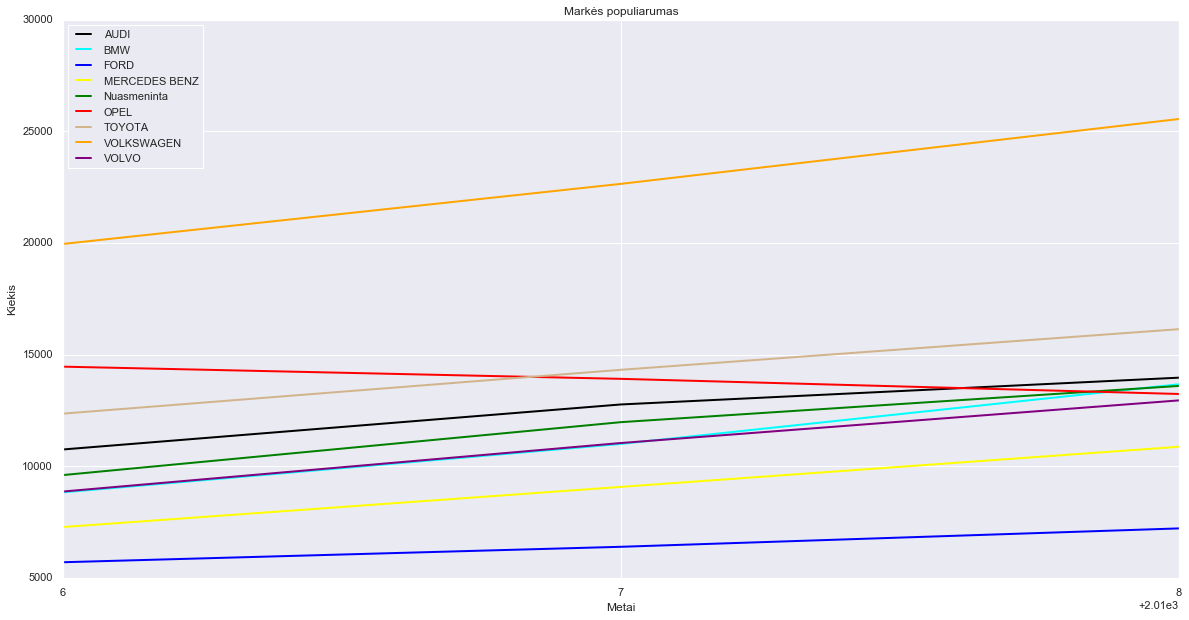

In [8]:

plt.figure(figsize=(20,10))
plt.xticks(np.arange(2016, 2020, 1.0))
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('AUDI'), marker='', color='black', linewidth=2, label='AUDI')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('BMW'), marker='', color='cyan', linewidth=2, label='BMW')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('FORD'), marker='', color='blue', linewidth=2, label='FORD')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('MERCEDES BENZ'), marker='', color='yellow', linewidth=2, label='MERCEDES BENZ')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('Nuasmeninta'), marker='', color='green', linewidth=2, label='Nuasmeninta')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('OPEL'), marker='', color='red', linewidth=2, label='OPEL')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('TOYOTA'), marker='', color='tan', linewidth=2, label='TOYOTA')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('VOLKSWAGEN'), marker='', color='Orange', linewidth=2, label='VOLKSWAGEN')
plt.plot( 'PIRM_REG_DATA_LT', 'MARKE_COUNT', data=grouped.get_group('VOLVO'), marker='', color='Purple', linewidth=2, label='VOLVO')


plt.legend(loc='best')

plt.xlabel('Metai')
plt.ylabel('Kiekis')
plt.title('Markės populiarumas')

#### Matoma, kad visus ketverius metus populiariausi buvo _VOLKSWAGEN_ automobiliai.   Taip pat iš grafiko matoma, kad visų automobilių išskyrus *OPEL* populiarumas didėja.

## Kaip keisis elektrinių automobolių naudojimas Lietuvoje?

In [9]:
fuel_data = raw_data[raw_data['DEGALAI'].notnull()]
fuel_data = fuel_data[fuel_data['DEGALAI'] != '--']
fuel_data['PIRM_REG_DATA_LT'] =pd.to_datetime(fuel_data['PIRM_REG_DATA_LT'], errors='coerce')
electrical_vehicle = fuel_data[fuel_data['DEGALAI'] == 'Elektra']

Sugrupuojami duomenys pagal metus ir mėnesį. Suskaičiuojama trukmė nuo pirmosios automobilio registracijos Lietuvoje mėnesiais.

In [10]:
per = electrical_vehicle['PIRM_REG_DATA_LT'].dt.to_period("M")
ev_grouped = electrical_vehicle.groupby(per)['PIRM_REG_DATA_LT'].count().to_frame('FUEL_COUNT').reset_index()
ev_grouped['MONTHS'] =  ((date.today().year - ev_grouped['PIRM_REG_DATA_LT'].dt.year) * 12 + date.today().month - ev_grouped['PIRM_REG_DATA_LT'].dt.month)  
ev_grouped.head()

,PIRM_REG_DATA_LT,FUEL_COUNT,MONTHS
0,2016-01,7,47
1,2016-02,7,46
2,2016-03,16,45
3,2016-04,21,44
4,2016-05,21,43


In [11]:
def func(x, a, b, c):  return a * np.exp(-b * x) + c
popt, pcov = curve_fit(func, ev_grouped['MONTHS'], ev_grouped['FUEL_COUNT'])
popt

array([6.19948863e+01, 4.58459911e-02, 7.32219886e+00])

Text(0.5, 1.0, 'Automobilių kiekis nuo 2016 iki 2019')

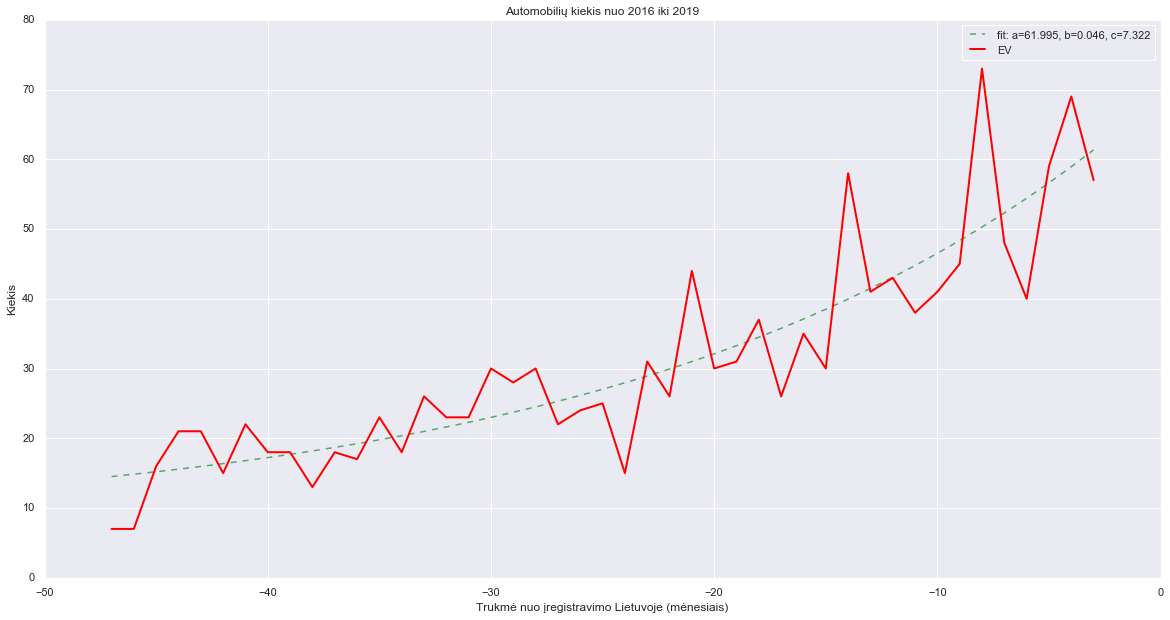

In [12]:
plt.figure(figsize=(20,10))
plt.plot( -1 * ev_grouped['MONTHS'], func(ev_grouped['MONTHS'],*popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ev_grouped['MONTHS'] = ev_grouped['MONTHS'] * -1
plt.plot( 'MONTHS', 'FUEL_COUNT', data=ev_grouped,  marker='', color='red', linewidth=2, label='EV')
plt.legend()
plt.xlabel('Trukmė nuo įregistravimo Lietuvoje (mėnesiais)')
plt.ylabel('Kiekis')
plt.title('Automobilių kiekis nuo 2016 iki 2019')

Pasinaudojus rastos lygties koeficientais, galime prognozuoti kad po 5 metų Lietuvoje kas mėnesį bus įregistruojama tarp 900 ir 1000 elektromobilių.

In [13]:
y = func(-60, popt[0], popt[1], popt[2])
y

977.8221632871572

Prognozės kreivė ateinantiems 5 metams (60 mėnesių)

Text(0.5, 1.0, 'EV kiekio prognozė (mėnesiais)')

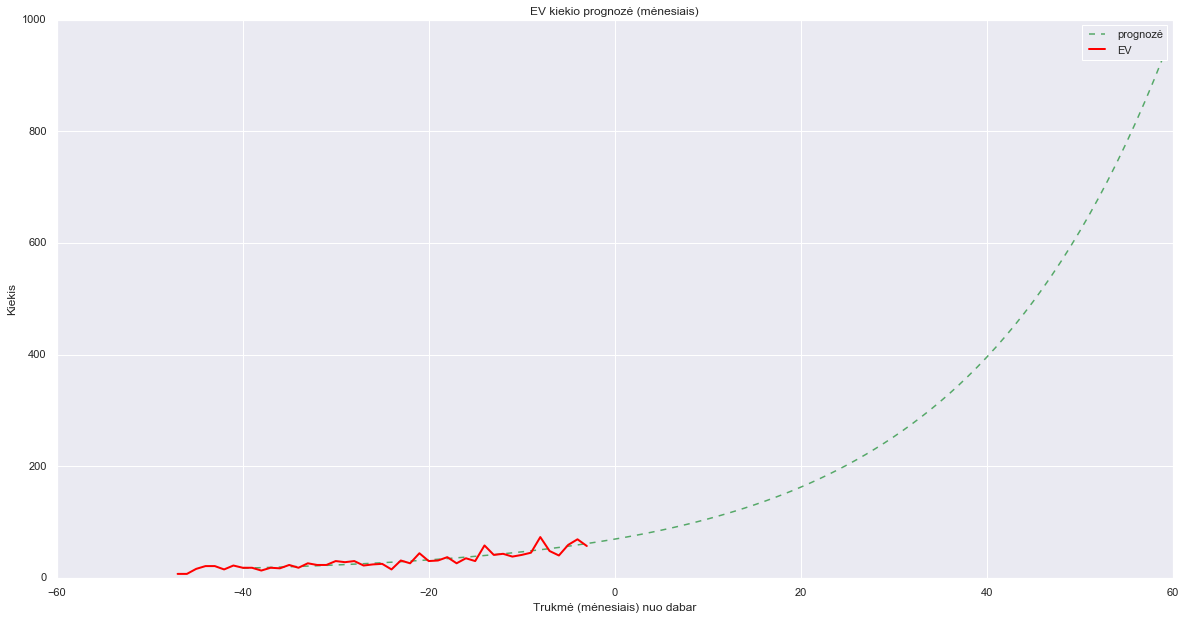

In [14]:
prediction = np.arange(-40, 60, 1)
plt.figure(figsize=(20,10))
plt.plot(prediction, func(-1 *prediction,*popt), 'g--', label='prognozė')
plt.plot( 'MONTHS', 'FUEL_COUNT', data=ev_grouped,  marker='', color='red', linewidth=2, label='EV')
plt.legend()
plt.xlabel('Trukmė (mėnesiais) nuo dabar')
plt.ylabel('Kiekis')
plt.title('EV kiekio prognozė (mėnesiais)')

#### Kaip matoma grafike elektromobilių skaičius turėtų sparčiai augti.

##  Kokiu tikslumu galima nustatyti automobilio kuro rūšį pagal  pirmos registracijos datą, sandorio datą ir kainą?

Išfiltruojam eilutes, kuriose yra visi reikiami laukai bei valiuta yra €.   
Po to pasirenkama automobilius, kurių kuras Dyzelinas arba Benzinas, kadangi kitų rūšių yra per mažai duomenų.

In [15]:
fuel_data = raw_data[raw_data['DEGALAI'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
fuel_data = fuel_data.drop(['MARKE', 'PIRM_REG_DATA_LT', 'PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA'], axis='columns')
fuel_data = fuel_data[(fuel_data['DEGALAI'] == 'Dyzelinas') | (fuel_data['DEGALAI'] == 'Benzinas')]
fuel_data['SANDORIO_DATA'] = pd.to_datetime(fuel_data['SANDORIO_DATA'], errors='coerce')
fuel_data['PIRM_REG_DATA'] = pd.to_datetime(fuel_data['PIRM_REG_DATA'], errors='coerce')
fuel_data['SANDORIO_DATA_DAYS'] = (date.today() - fuel_data['SANDORIO_DATA'].dt.date).dt.days
fuel_data['PIRM_REG_DATA_DAYS'] = (date.today() - fuel_data['PIRM_REG_DATA'].dt.date).dt.days
fuel_data = fuel_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA', 'DARBINIS_TURIS', 'GALIA'], axis='columns')
fuel_data = fuel_data[fuel_data['PIRM_REG_DATA_DAYS'] > 0]
fuel_data = fuel_data[fuel_data['SANDORIO_DATA_DAYS'] > 0]
fuel_data = fuel_data[fuel_data['SANDORIO_SUMA'] > 1000]
fuel_data = fuel_data[fuel_data['SANDORIO_SUMA'] < 500000]
fuel_data.head(10)

,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
0,Dyzelinas,25000.0,1793,1428
1,Benzinas,33900.0,1793,1426
3,Dyzelinas,3500.0,1785,8099
5,Benzinas,11700.0,1777,1419
8,Dyzelinas,9000.0,1643,8522
9,Dyzelinas,38500.0,1641,1428
12,Dyzelinas,22000.0,1602,6814
13,Dyzelinas,71245.0,1600,1427
14,Dyzelinas,71245.0,1600,1427
15,Benzinas,78854.0,1596,1421


In [16]:
df0 = fuel_data[fuel_data['DEGALAI'] == "Benzinas" ]
len(df0)

21790

In [17]:
df1 = fuel_data[fuel_data['DEGALAI'] == "Dyzelinas" ].head(len(df0))
len(df1)

21790

In [18]:
fuel_data = pd.concat([df0, df1])
len(fuel_data)

43580

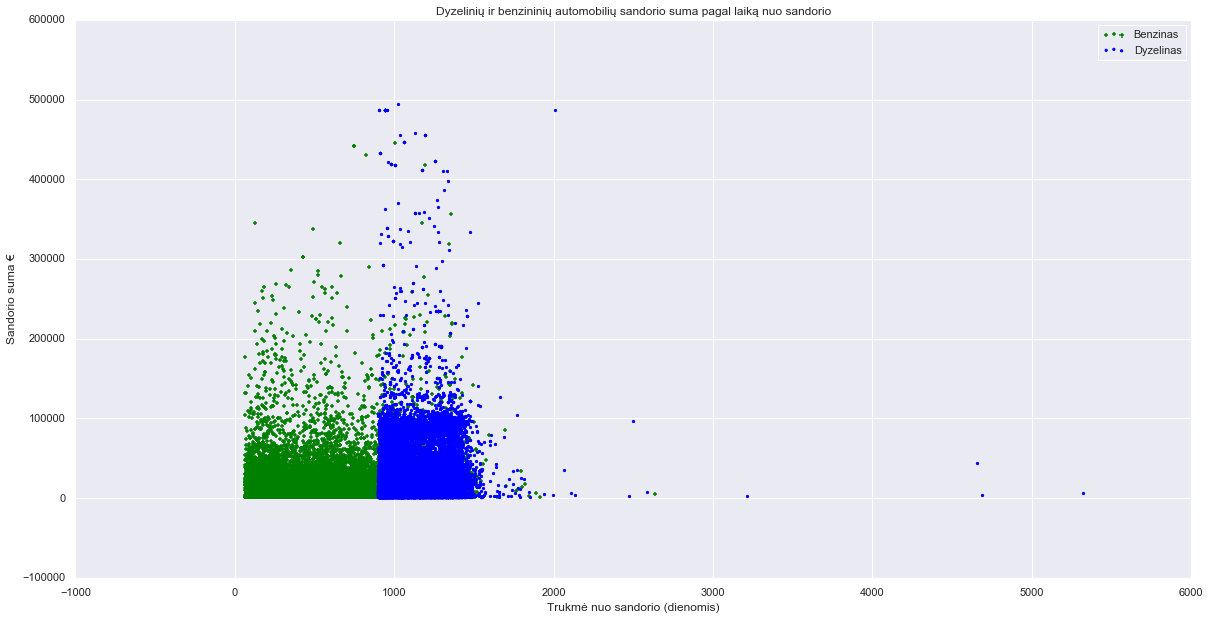

In [19]:
plt.figure(figsize=(20,10))
plt.ylabel('Sandorio suma €')
plt.xlabel('Trukmė nuo sandorio (dienomis)')
plt.scatter( df0['SANDORIO_DATA_DAYS'], df0['SANDORIO_SUMA'],color="green",marker='+', label='Benzinas')
plt.scatter( df1['SANDORIO_DATA_DAYS'], df1['SANDORIO_SUMA'],color="blue",marker='.', label='Dyzelinas')
plt.title('Dyzelinių ir benzininių automobilių sandorio suma pagal laiką nuo sandorio')
plt.legend()

### Pasirenkamas K artimiausių kaimynų klasifikatorius

In [20]:
X = fuel_data.drop(['DEGALAI'], axis='columns')
y = fuel_data['DEGALAI']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(len(X_train))
print(len(X_test))



37043
6537


In [22]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [23]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score   


0.8903166590178981

## Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?


In [24]:
brand_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
brand_data = brand_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'DEGALAI', 'PIRM_REG_DATA_LT'], axis='columns')
brand_data = brand_data[
                           (brand_data['MARKE'] == 'VOLKSWAGEN') 
                        | (brand_data['MARKE'] == 'AUDI')
                        | (brand_data['MARKE'] == 'TOYOTA')
                        | (brand_data['MARKE'] == 'BMW')
                        | (brand_data['MARKE'] == 'OPEL')
                        | (brand_data['MARKE'] == 'MERCEDES BENZ')
                        | (brand_data['MARKE'] == 'VOLVO')
                        | (brand_data['MARKE'] == 'FORD')
                       ]



In [25]:
brand_data['SANDORIO_DATA'] = pd.to_datetime(brand_data['SANDORIO_DATA'], errors='coerce')
brand_data['PIRM_REG_DATA'] = pd.to_datetime(brand_data['PIRM_REG_DATA'], errors='coerce')
brand_data['SANDORIO_DATA_DAYS'] = (date.today() - brand_data['SANDORIO_DATA'].dt.date).dt.days
brand_data['PIRM_REG_DATA_DAYS'] = (date.today() - brand_data['PIRM_REG_DATA'].dt.date).dt.days

brand_data = brand_data[brand_data['PIRM_REG_DATA_DAYS'] > 0]
brand_data = brand_data[brand_data['SANDORIO_DATA_DAYS'] > 0]
brand_data = brand_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')
brand_data.head()

,MARKE,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,3500.0,90.0,2874.0,1785,8099
7,VOLKSWAGEN,900.0,55.0,1781.0,1695,9345
13,VOLKSWAGEN,71245.0,103.0,1968.0,1600,1427
14,VOLKSWAGEN,71245.0,103.0,1968.0,1600,1427
15,BMW,78854.0,225.0,2979.0,1596,1421


In [26]:
X1 = brand_data.drop(['MARKE'], axis='columns')
y1 = brand_data['MARKE']

### Pasirenkamas atsitiktinių miškų klasifikatorius

In [27]:

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15)

print(len(X1_train))
print(len(X1_test))


63771
11254


In [28]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X1_train)
X1_train = scaling.transform(X1_train)
X1_test = scaling.transform(X1_test)

In [29]:
model1 = RandomForestClassifier(n_estimators=100, random_state=10)
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [30]:
model1.score(X1_test, y1_test)

0.9614359338901723

## Kokiu tikslumu galima nustatyti automobilio kainą?

In [31]:
price_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
price_data = price_data[
                          (price_data['MARKE'] == 'VOLKSWAGEN') 
                        | (price_data['MARKE'] == 'AUDI')
                        | (price_data['MARKE'] == 'TOYOTA')
                        | (price_data['MARKE'] == 'BMW')
                        | (price_data['MARKE'] == 'OPEL')
                        | (price_data['MARKE'] == 'MERCEDES BENZ')
                        | (price_data['MARKE'] == 'VOLVO')
                        | (price_data['MARKE'] == 'FORD')
                       ]


price_data = price_data[(price_data['DEGALAI'] == 'Dyzelinas') | (price_data['DEGALAI'] == 'Benzinas')]

price_data = price_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'PIRM_REG_DATA_LT'], axis='columns')

price_data.sort_values(by=['SANDORIO_SUMA' ,'DARBINIS_TURIS'], ascending=False).head(10)

,MARKE,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
143729,MERCEDES BENZ,Dyzelinas,9120980.0,2016-04-08,310.0,12809.0,2016-04-19
596034,MERCEDES BENZ,Dyzelinas,9033860.0,2018-05-02,310.0,12809.0,2018-08-24
566501,MERCEDES BENZ,Dyzelinas,8650653.0,2017-10-27,330.0,12809.0,2017-10-28
581100,MERCEDES BENZ,Dyzelinas,8576480.0,2018-02-12,330.0,12809.0,2018-03-06
636667,MERCEDES BENZ,Dyzelinas,4774502.0,2018-12-13,190.0,2987.0,2017-05-11
659913,VOLKSWAGEN,Dyzelinas,3513219.0,2019-04-23,75.0,1968.0,2017-02-14
149359,AUDI,Dyzelinas,3016807.0,2016-06-23,230.0,2967.0,2013-04-17
561787,FORD,Dyzelinas,2754807.0,2017-09-26,96.0,1995.0,2017-09-29
653198,TOYOTA,Benzinas,1919092.0,2019-03-21,129.0,1987.0,2019-04-10
673101,BMW,Dyzelinas,1605011.0,2019-06-30,190.0,2993.0,2013-05-28


In [32]:
price_data['SANDORIO_DATA'] = pd.to_datetime(price_data['SANDORIO_DATA'], errors='coerce')
price_data['PIRM_REG_DATA'] = pd.to_datetime(price_data['PIRM_REG_DATA'], errors='coerce')
price_data['SANDORIO_DATA_DAYS'] = (date.today() - price_data['SANDORIO_DATA'].dt.date).dt.days
price_data['PIRM_REG_DATA_DAYS'] = (date.today() - price_data['PIRM_REG_DATA'].dt.date).dt.days
price_data = price_data[price_data['PIRM_REG_DATA_DAYS'] > 0]
price_data = price_data[price_data['SANDORIO_DATA_DAYS'] > 0]
price_data = price_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')


In [33]:
df0 = price_data[price_data['DEGALAI'] == 'Dyzelinas']
df1 = price_data[price_data['DEGALAI'] == 'Benzinas']

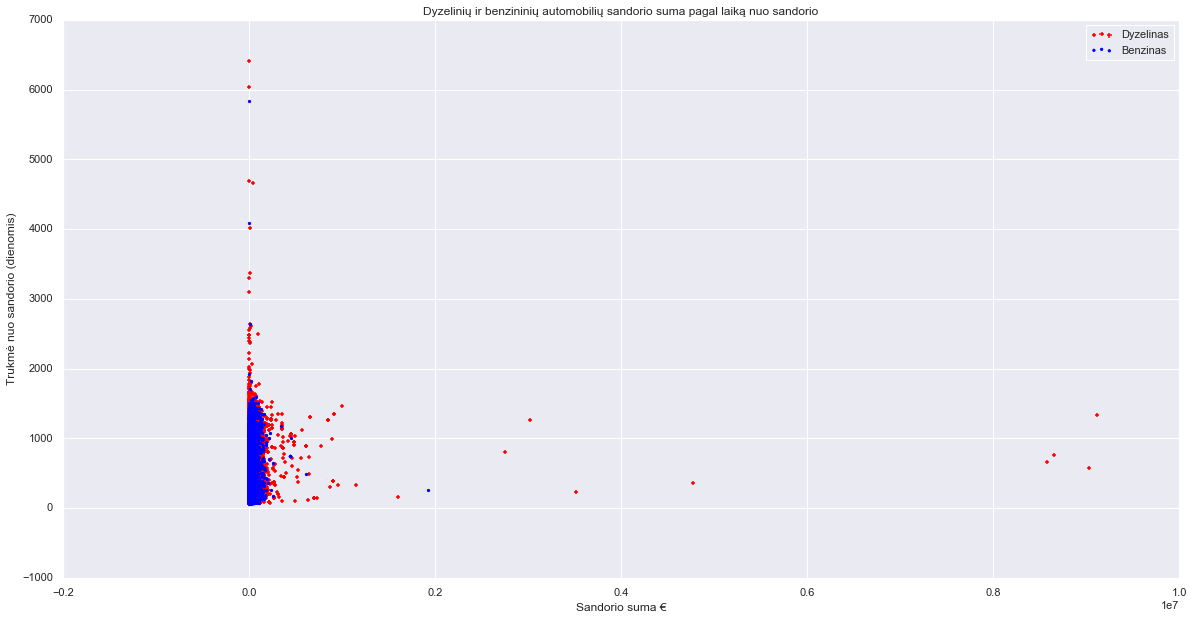

In [34]:

plt.figure(figsize=(20,10))
plt.xlabel('Sandorio suma €')
plt.ylabel('Trukmė nuo sandorio (dienomis)')

plt.scatter(df0['SANDORIO_SUMA'], df0['SANDORIO_DATA_DAYS'],color="red",marker='+', label='Dyzelinas')
plt.scatter(df1['SANDORIO_SUMA'], df1['SANDORIO_DATA_DAYS'],color="blue",marker='.', label='Benzinas')
plt.title('Dyzelinių ir benzininių automobilių sandorio suma pagal laiką nuo sandorio')
plt.legend()

Text(0.5, 1.0, 'Kainos pagal markę')

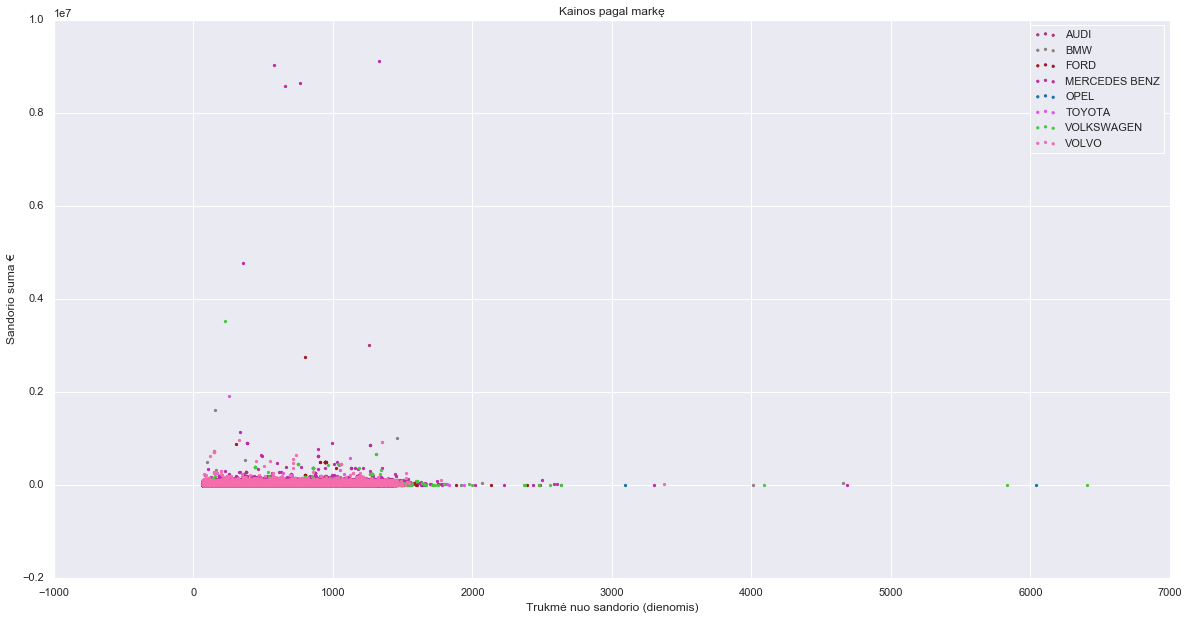

In [35]:
grouped_marke = price_data.groupby(['MARKE'])
plt.figure(figsize=(20,10))

for key, item in grouped_marke:
    plt.scatter( 'SANDORIO_DATA_DAYS', 'SANDORIO_SUMA', data=grouped_marke.get_group(key), color=np.random.rand(3,), marker='.', label=key)
plt.legend()
plt.ylabel('Sandorio suma €')
plt.xlabel('Trukmė nuo sandorio (dienomis)')
plt.title('Kainos pagal markę')

Text(0.5, 1.0, 'Kainos priklausomybė nuo automobilio darbinio tūrio')

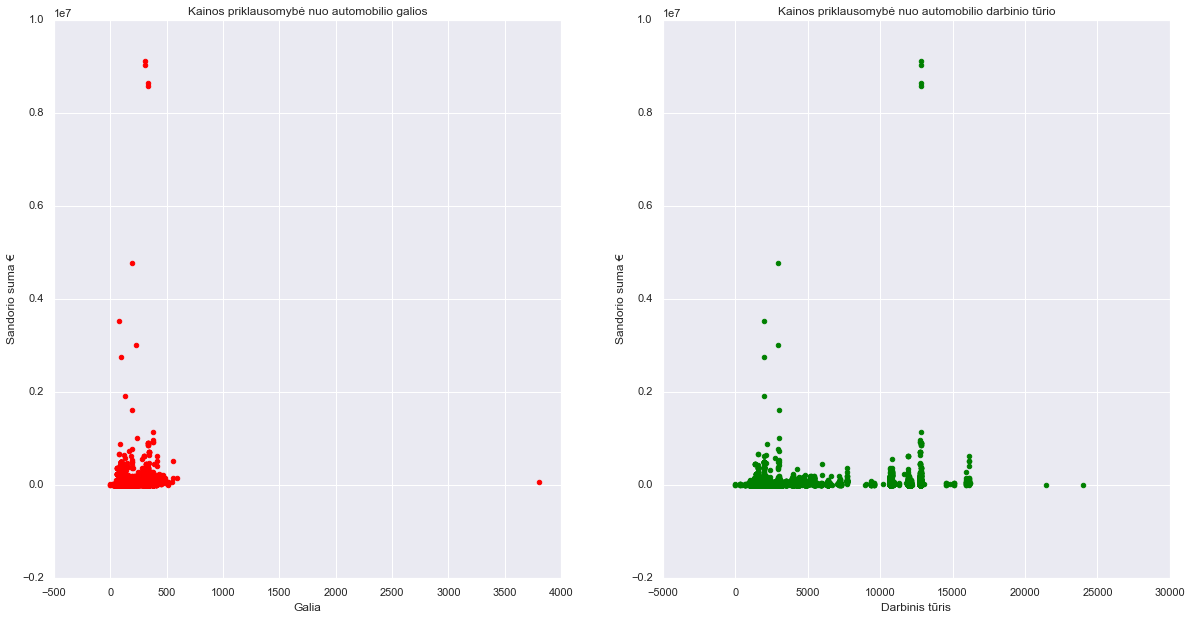

In [36]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Galia')
plt.ylabel('Sandorio suma €')
plt.title('Kainos priklausomybė nuo automobilio galios')
plt.scatter(price_data['GALIA'], price_data['SANDORIO_SUMA'],color="red",)


plt.subplot(1,2,2)
plt.scatter(price_data['DARBINIS_TURIS'], price_data['SANDORIO_SUMA'],color="green")
plt.xlabel('Darbinis tūris')
plt.ylabel('Sandorio suma €')
plt.title('Kainos priklausomybė nuo automobilio darbinio tūrio')

Nuspręsta kainų prognozę vykdyti nuo 500 iki 50000 €, kadangi pigesnių ir brangesnių automobilių yra labai nedaug duomenų ir jie stipriai paveikia bendrą tikslumą.


In [37]:
price_data = price_data[price_data['SANDORIO_SUMA'] > 500]
price_data = price_data[price_data['SANDORIO_SUMA'] < 50000]
price_data.head()

,MARKE,DEGALAI,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,Dyzelinas,3500.0,90.0,2874.0,1785,8099
20,BMW,Benzinas,42814.8,135.0,1997.0,1559,1418
21,VOLKSWAGEN,Dyzelinas,1115.5,80.0,2460.0,1546,7241
22,BMW,Benzinas,21700.0,110.0,1499.0,1543,1413
24,VOLKSWAGEN,Dyzelinas,20050.0,81.0,1968.0,1540,1413


Taip pat pastebėta, kad duomenų rinkinyje yra automobilių, kurių darbinis tūris yra netoli 20L šie automobiliai greičiausiai yra sunkesvoriai, todėl nuspręsta naudoti duomenis nuo 0 iki 5l (5000)

In [38]:
price_data = price_data[price_data['DARBINIS_TURIS'] < 4000]


#### Sumaišome duomenis bei pasirenkame pirmus 10 tūkstančių.

In [39]:
from sklearn.utils import shuffle
price_data = shuffle(price_data)
price_data = price_data.head(10000)

### Naudojamas "One hot encoding", kadangi  automobilio markė ir kuro rūšis yra eilutės formato ir negali būti naudojama modelio apmokymui

In [40]:
X2 = price_data
X2 = pd.get_dummies(data=X2)
X2.head()

,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS,MARKE_AUDI,MARKE_BMW,MARKE_FORD,MARKE_MERCEDES BENZ,MARKE_OPEL,MARKE_TOYOTA,MARKE_VOLKSWAGEN,MARKE_VOLVO,DEGALAI_Benzinas,DEGALAI_Dyzelinas
175308,1000.00,110.0,1781.0,934,6304,0,0,0,0,0,0,1,0,1,0
176873,19008.27,118.0,1498.0,917,917,0,0,1,0,0,0,0,0,1,0
619158,4950.00,85.0,2198.0,455,3315,0,0,1,0,0,0,0,0,0,1
153431,16200.00,81.0,1598.0,1190,1131,0,0,0,0,0,0,1,0,0,1
680286,1000.00,110.0,1995.0,115,5554,0,1,0,0,0,0,0,0,0,1


In [41]:
X2 = X2.drop([ 'SANDORIO_SUMA'], axis='columns')
y2 = price_data['SANDORIO_SUMA']

In [42]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

print(len(X2_train))
print(len(X2_test))


8000
2000


In [43]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X2_train)
X2_train = scaling.transform(X2_train)
X2_test = scaling.transform(X2_test)

### Pasirenkama "Gradient Boosting" regresija, kadangi pabandžius artimiausių kaimynų regresiją ir "Gradient Boosting" regresija, ši pasižymėjo žymiai geresniu rezultatu

In [44]:
gradient_model =  GradientBoostingRegressor(loss ='ls', max_depth=5)

gradient_model.fit (X2_train, y2_train)
score = gradient_model.score(X2_test, y2_test)
predicted = gradient_model.predict(X2_test)
difference = y2_test - predicted

Text(0, 0.5, 'Prognozuojama kaina €')

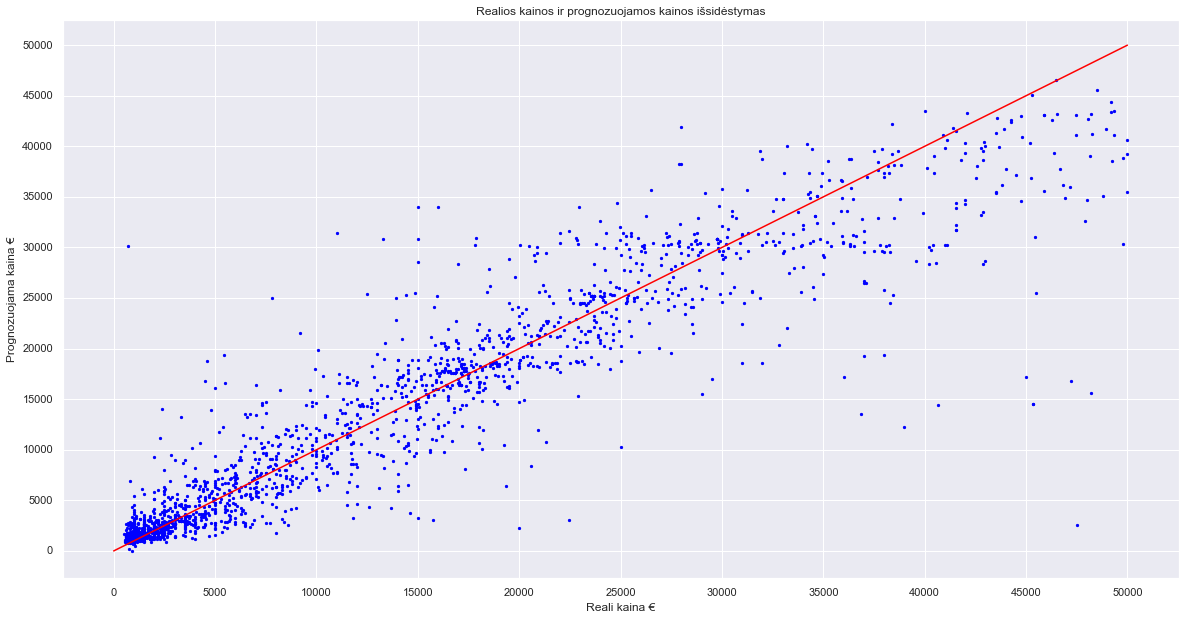

In [45]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, 55000, 5000))
plt.yticks(np.arange(0, 55000, 5000))
plt.scatter(y2_test , predicted,  marker='.', color='blue' )
plt.plot(np.arange(0, 50000, 1), np.arange(0, 50000, 1), color='red')
plt.title('Realios kainos ir prognozuojamos kainos išsidėstymas')
plt.xlabel('Reali kaina €')
plt.ylabel('Prognozuojama kaina €')

In [46]:
rmse = np.sqrt(mean_squared_error(y2_test, predicted))
scores = cross_val_score(gradient_model, X2, y2, cv=5)

In [47]:

print('\nKryžminės validacijos rezultatai:')
print(scores)
print('\nVidutinis rezultatas:')
print(scores.mean())
print('\nRoot mean square error:')
print(rmse)

print('Regresijos rezultas: %.2f' % r2_score(y2_test, predicted))


Kryžminės validacijos rezultatai:
[0.90445313 0.90795497 0.89077315 0.88701286 0.87654406]

Vidutinis rezultatas:
0.8933476320876748

Root mean square error:
4413.043931296709
Regresijos rezultas: 0.88


## Išvados, pastebėjimai

#### 1 mini projekto išvados

1. Daugiausiai dyzelinių automobilių eksportuojama iš Vokietijos ir Prancūzijos, o benzininių iš Vokietijos.
1. Populiariausi automobiliai yra VOLKSWAGEN markės.
1. Visų išskyrus OPEL markių automobilių populiarumas kasmet didėjo per praėjusius 3 metus.
1. Elektromobilių kiekio prognozėje matome, kad šių tipo automobilių kiekis sparčiai augs.

#### 2 mini projekto išvados

1. Su turimais duomenimis sėkmingiau pavyko nustatyti automobilio markę (apie 96 % tikslumas) nei automobilio kuro rūšį (apie 90 % tikslumas). Markės buvo klasifikuojamos į 8 tipus, o automobilio kuras į du.
1. Prognozuojant kainą gerą rezultatą pavyko pasiekti tik tada, kai buvo nuspręsta naudoti automobilių, kurie kainuoja nuo 1000 iki 50000 € duomenis.
1. Taip pat rezultatas šiek tiek pagerėjo (apie vidutinis rezultatas pagerėjo apie 0.03), kai buvo nuspręsta naudoti tik tų automobilių duomenis, kurių darbinis tūris neviršija 5l (dažniausiai tik sportinių automobilių darbinis tūris yra didesnis nei 5l).
1. Kainų prognozei tego panaudoti "One hot encoding", kadangi buvo naudojami kuro bei markės duomenys.
